# 1. Importer les bibliothèques nécessaires

In [1]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt


# 2. Chargement et prétraitement des images

In [2]:
def load_images_from_folder(folder_path):
    images = []
    labels = []
    categories = os.listdir(folder_path)

    for category in categories:
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for file_name in os.listdir(category_path):
                if file_name.endswith('.tif'):  # Charge uniquement les fichiers .tif
                    file_path = os.path.join(category_path, file_name)
                    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    if image is not None:
                        images.append(image)
                        labels.append(category)  # La catégorie devient l'étiquette
    return images, labels

# Exemple d'utilisation
data_path = "/kaggle/input/ucmerced-landuse/UCMerced_LandUse/Images"  
images, labels = load_images_from_folder(data_path)


In [3]:
images, labels = load_images_from_folder(data_path)

print(f"Nombre total d'images chargées : {len(images)}")
print(f"Nombre total d'étiquettes : {len(labels)}")


Nombre total d'images chargées : 2100
Nombre total d'étiquettes : 2100


In [4]:
from collections import Counter

# Comptez les occurrences de chaque étiquette
distribution = Counter(labels)
print("Distribution des images par classe :", distribution)


Distribution des images par classe : Counter({'airplane': 100, 'tenniscourt': 100, 'river': 100, 'denseresidential': 100, 'parkinglot': 100, 'storagetanks': 100, 'overpass': 100, 'sparseresidential': 100, 'mediumresidential': 100, 'intersection': 100, 'baseballdiamond': 100, 'runway': 100, 'chaparral': 100, 'freeway': 100, 'beach': 100, 'buildings': 100, 'harbor': 100, 'mobilehomepark': 100, 'forest': 100, 'golfcourse': 100, 'agricultural': 100})


# 3. Fractionnement du jeu de données

In [5]:
from collections import defaultdict
import numpy as np

def custom_split(images, labels, test_size=0.2, random_state=None):
    """
    Fractionne les images et labels en ensembles d'entraînement et de test tout en maintenant l'équilibre des catégories.

    Args:
        images (list): Liste des images.
        labels (list): Liste des étiquettes correspondantes.
        test_size (float): Proportion du jeu de test (entre 0 et 1).
        random_state (int, optional): Graine pour assurer la reproductibilité.

    Returns:
        train_images, test_images, train_labels, test_labels
    """
    if random_state is not None:
        np.random.seed(random_state)

    # Regrouper les images par catégorie
    label_to_images = defaultdict(list)
    for img, label in zip(images, labels):
        label_to_images[label].append(img)

    # Fractionner les données pour chaque catégorie
    train_images, test_images = [], []
    train_labels, test_labels = [], []

    for label, imgs in label_to_images.items():
        np.random.shuffle(imgs)
        split_idx = int(len(imgs) * (1 - test_size))
        
        train_images.extend(imgs[:split_idx])
        test_images.extend(imgs[split_idx:])
        train_labels.extend([label] * split_idx)
        test_labels.extend([label] * (len(imgs) - split_idx))

    return train_images, test_images, train_labels, test_labels


In [6]:
# Exemple d'utilisation
train_images, test_images, train_labels, test_labels = custom_split(
    images, labels, test_size=0.2, random_state=42
)


In [7]:
from collections import Counter

print("Distribution dans l'ensemble d'entraînement :", Counter(train_labels))
print("Distribution dans l'ensemble de test :", Counter(test_labels))


Distribution dans l'ensemble d'entraînement : Counter({'airplane': 80, 'tenniscourt': 80, 'river': 80, 'denseresidential': 80, 'parkinglot': 80, 'storagetanks': 80, 'overpass': 80, 'sparseresidential': 80, 'mediumresidential': 80, 'intersection': 80, 'baseballdiamond': 80, 'runway': 80, 'chaparral': 80, 'freeway': 80, 'beach': 80, 'buildings': 80, 'harbor': 80, 'mobilehomepark': 80, 'forest': 80, 'golfcourse': 80, 'agricultural': 80})
Distribution dans l'ensemble de test : Counter({'airplane': 20, 'tenniscourt': 20, 'river': 20, 'denseresidential': 20, 'parkinglot': 20, 'storagetanks': 20, 'overpass': 20, 'sparseresidential': 20, 'mediumresidential': 20, 'intersection': 20, 'baseballdiamond': 20, 'runway': 20, 'chaparral': 20, 'freeway': 20, 'beach': 20, 'buildings': 20, 'harbor': 20, 'mobilehomepark': 20, 'forest': 20, 'golfcourse': 20, 'agricultural': 20})


# 4. Extraction des caractéristiques SIFT

In [8]:
def extract_sift_features(images, labels):
    sift = cv2.SIFT_create()
    descriptors_list = []
    updated_labels = []
    for img, label in zip(images, labels):
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:  # Vérifie que des descripteurs ont été trouvés
            descriptors_list.append(descriptors)
            updated_labels.append(label)
    return descriptors_list, updated_labels

train_descriptors, train_labels = extract_sift_features(train_images, train_labels)
test_descriptors, test_labels = extract_sift_features(test_images, test_labels)


# 5. Construction du vocabulaire visuel

In [9]:
def build_visual_vocabulary(descriptors_list, num_clusters=100):
    all_descriptors = np.vstack(descriptors_list)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans

num_clusters = 100
kmeans = build_visual_vocabulary(train_descriptors, num_clusters)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
from sklearn.metrics import pairwise_distances_argmin

def quantize_descriptors(descriptors, kmeans):
    """
    Affecte chaque descripteur au mot visuel le plus proche dans le vocabulaire visuel.
    
    Args:
        descriptors (ndarray): Descripteurs de l'image (n x d).
        kmeans (KMeans): Modèle KMeans ajusté qui contient les mots visuels (centres de clusters).
        
    Returns:
        quantized_labels (list): Liste des indices des mots visuels pour chaque descripteur.
    """
    # Trouver les indices des mots visuels les plus proches pour chaque descripteur
    quantized_labels = pairwise_distances_argmin(descriptors, kmeans.cluster_centers_)
    return quantized_labels

# Quantification des descripteurs d'entraînement et de test
train_quantized_labels = []
for descriptors in train_descriptors:
    quantized_labels = quantize_descriptors(descriptors, kmeans)
    train_quantized_labels.append(quantized_labels)

test_quantized_labels = []
for descriptors in test_descriptors:
    quantized_labels = quantize_descriptors(descriptors, kmeans)
    test_quantized_labels.append(quantized_labels)


# 6. Création des histogrammes

In [11]:
from collections import Counter
import numpy as np

def create_histogram(quantized_labels, num_words):
    """
    Crée un histogramme de mots visuels à partir des labels quantifiés.
    
    Args:
        quantized_labels (list): Liste des indices des mots visuels pour chaque descripteur.
        num_words (int): Nombre total de mots visuels.
        
    Returns:
        hist_vector (ndarray): Vecteur d'histogramme de taille (num_words,).
    """
    histogram = Counter(quantized_labels)
    hist_vector = np.zeros(num_words)
    for word, count in histogram.items():
        hist_vector[word] = count
    return hist_vector

# Créer des histogrammes pour les images d'entraînement et de test
train_histograms = []
for quantized_labels in train_quantized_labels:
    hist_vector = create_histogram(quantized_labels, num_clusters)
    train_histograms.append(hist_vector)

test_histograms = []
for quantized_labels in test_quantized_labels:
    hist_vector = create_histogram(quantized_labels, num_clusters)
    test_histograms.append(hist_vector)

# 'train_histograms' et 'test_histograms' contiendront les histogrammes pour chaque image


# 7. Normalisation des histogrammes

In [19]:
def normalize_histograms(histograms):
    normalized = histograms / np.linalg.norm(histograms, axis=1, keepdims=True)
    return normalized

train_histograms = normalize_histograms(train_histograms)
test_histograms = normalize_histograms(test_histograms)


# 8. Entraînement du classificateur (SVM)

In [20]:
svm = SVC(kernel='linear', random_state=42)
svm.fit(train_histograms, train_labels)


SVC(kernel='linear', random_state=42)

# 9. Prédiction et évaluation

In [21]:
# Prédictions sur le jeu de test
test_predictions = svm.predict(test_histograms)

# Calcul de la précision
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Précision : {accuracy * 100:.2f}%")



Précision : 64.20%


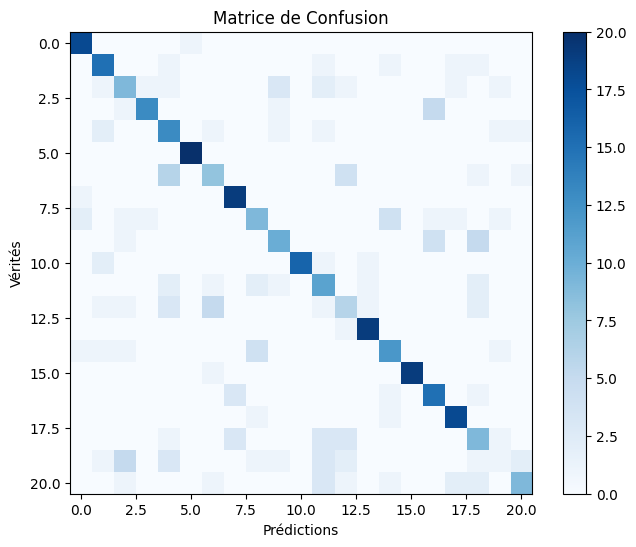

In [23]:
# Matrice de confusion
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()


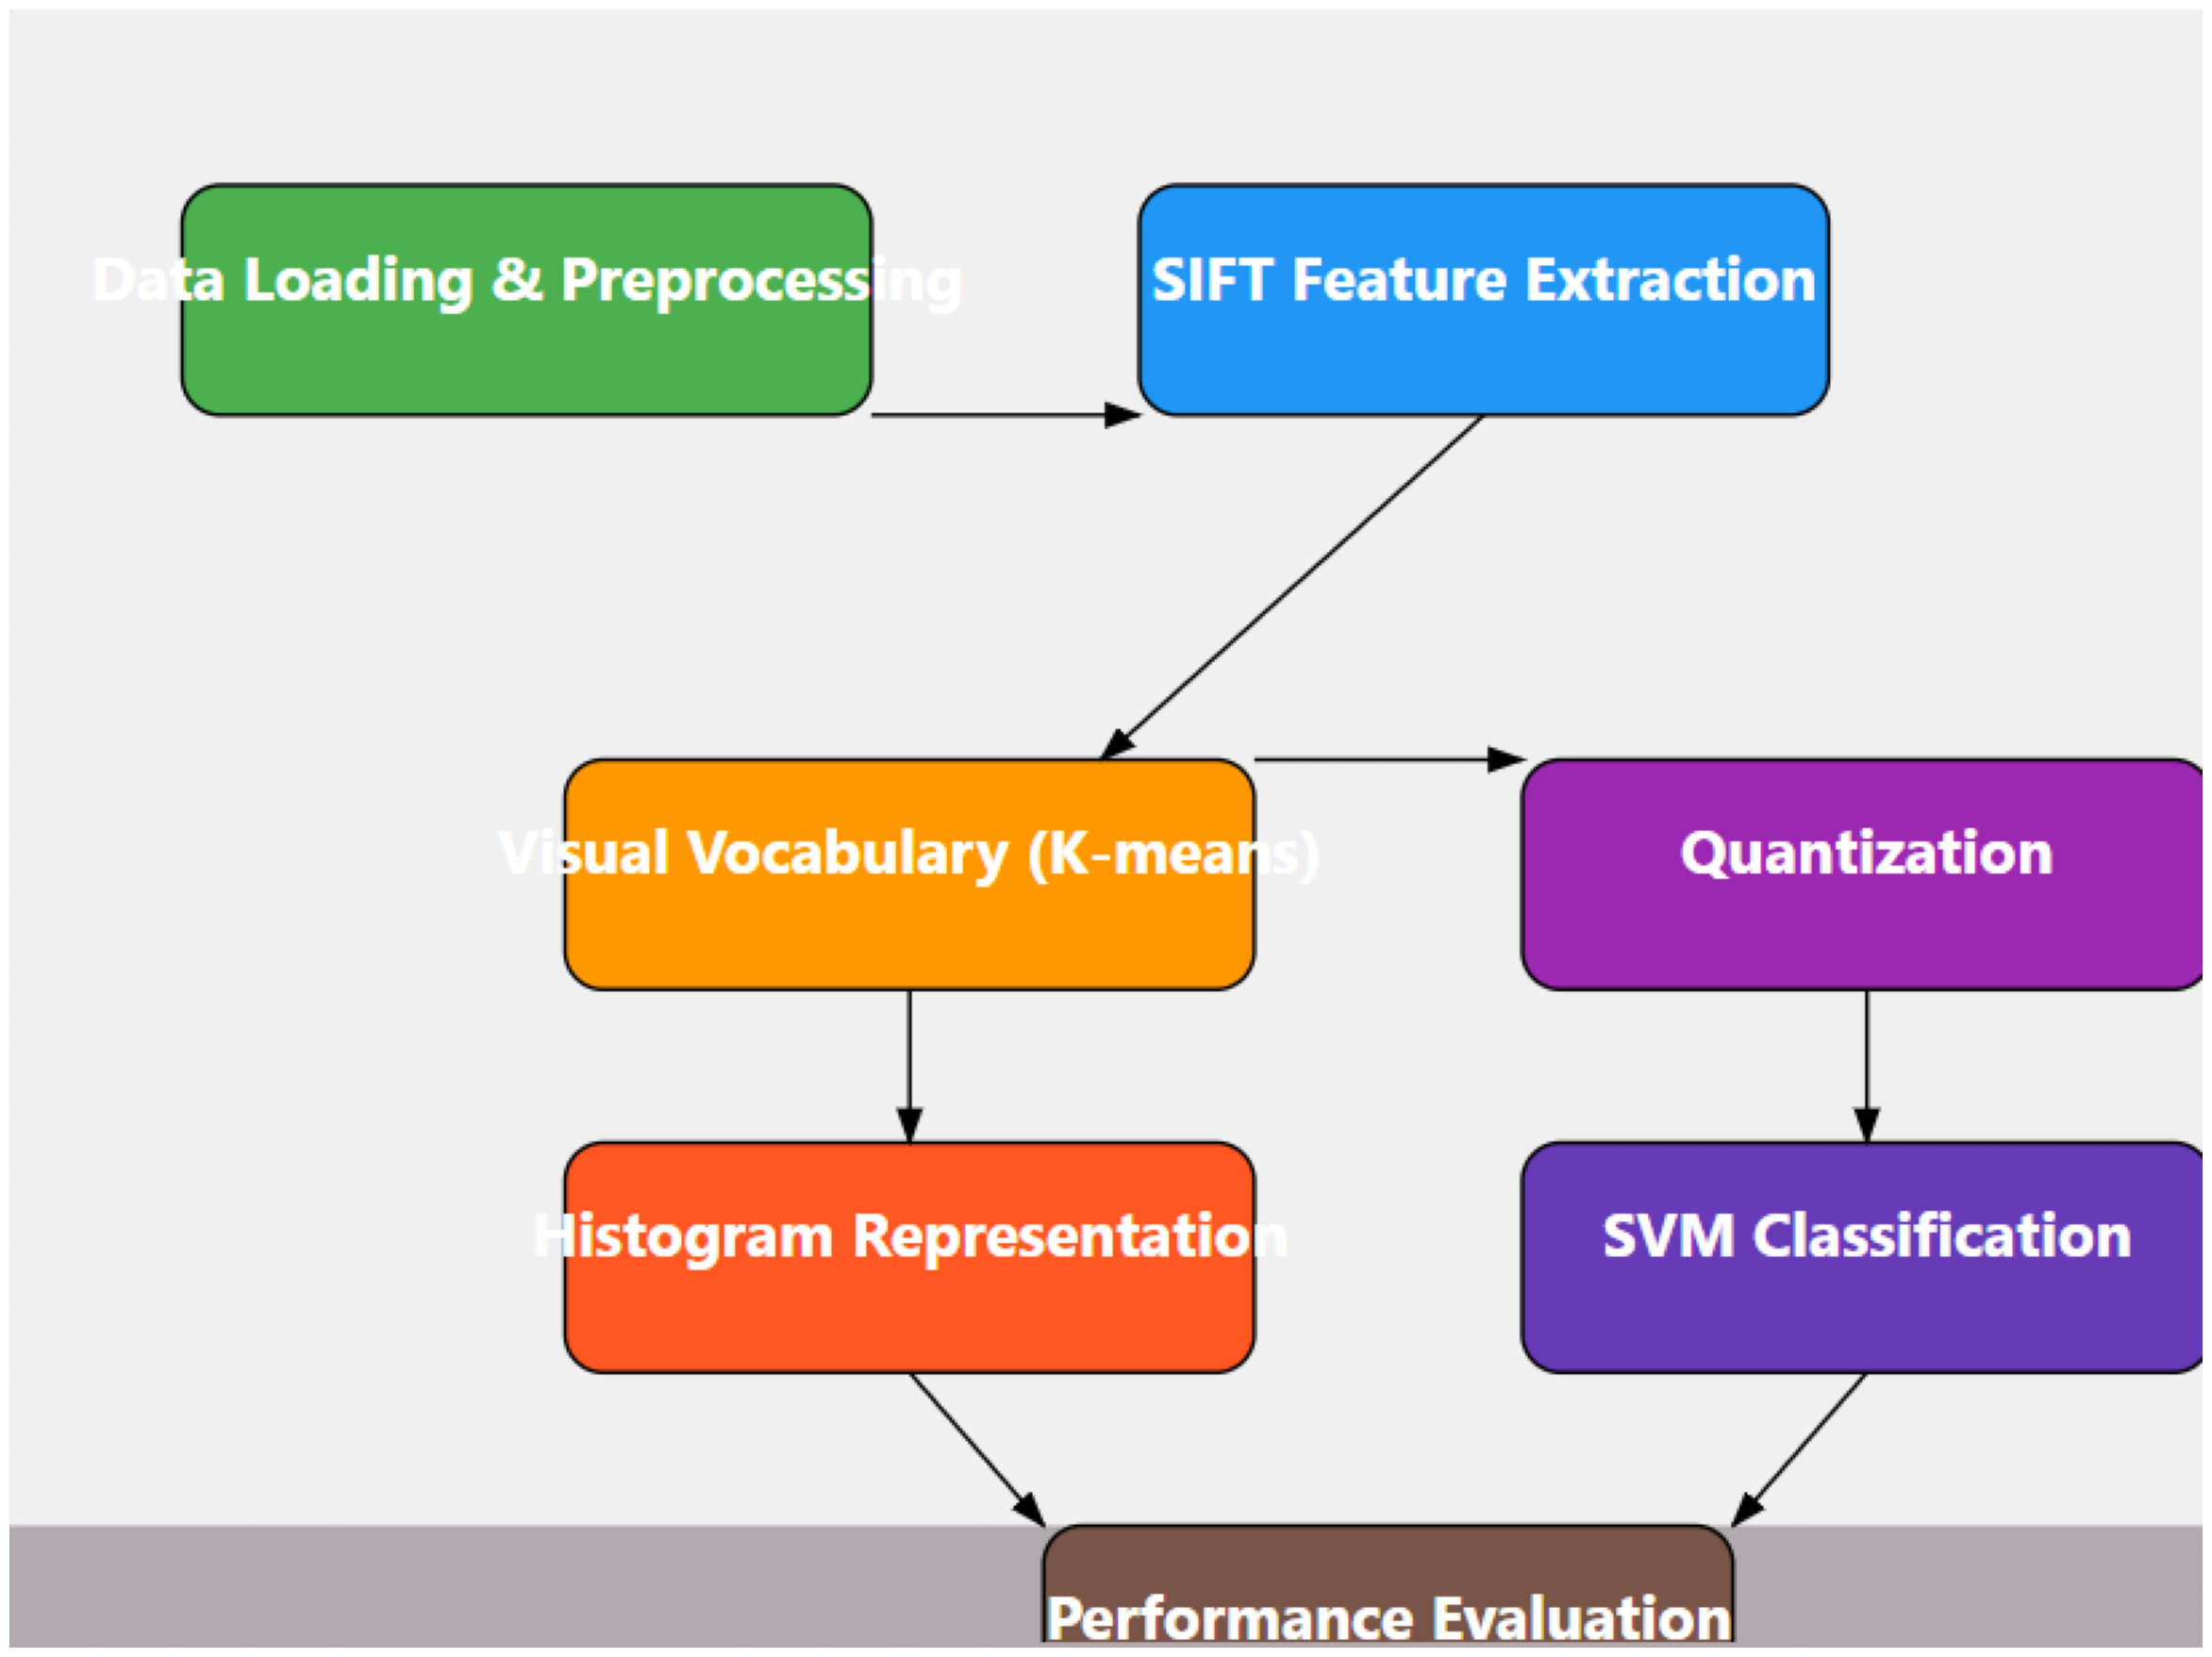

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread("/kaggle/input/diagramme/Screenshot 2024-11-19 195308.png")
plt.figure(figsize=(30, 30)) 
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()